In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

device = 'cuda'

/vol/tensusers3/jdusseljee/2324-asr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tensor_transform = transforms.ToTensor()

In [3]:
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

In [4]:
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 512,
                                     shuffle = True)

In [5]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = AE().to(device)
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss().to(device)
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

In [7]:
epochs = 100
outputs = []
losses = []
for epoch in tqdm(range(epochs)):
    losses_epoch = 0
    for (image, _) in loader:
       
      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 28*28).to(device)
       
      # Output of Autoencoder
      reconstructed = model(image)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, image)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses_epoch += loss.cpu().detach()
    losses.append(losses_epoch / len(loader))
    outputs.append((epoch, image.cpu(), reconstructed.cpu().detach()))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses)

 13%|█▎        | 13/100 [01:22<09:10,  6.33s/it]


KeyboardInterrupt: 

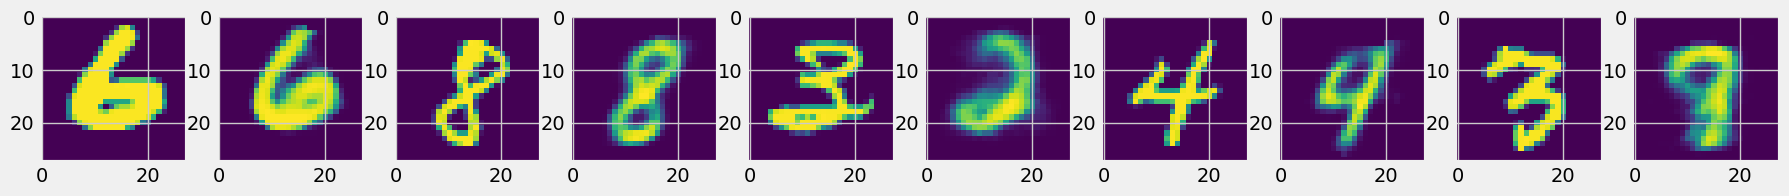

In [ ]:
fig, ax = plt.subplots(1,10, figsize=(20, 2))

i = 29

for j in range(5):
  # Reshape the array for plotting
  src = outputs[i][1][j].reshape(-1, 28, 28)
  ax[j*2+0].imshow(src[0])

  output = outputs[i][2][j].reshape(-1, 28, 28)
  ax[j*2+1].imshow(output[0])
 


In [ ]:
encoder = model.cpu().encoder

vectors = []

for (image, _) in loader:
  image = image.reshape(-1, 28*28)

  results = encoder(image)
  vectors.extend(results.detach())

vectors = np.array([x.numpy() for x in vectors])


In [ ]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42).fit(vectors)

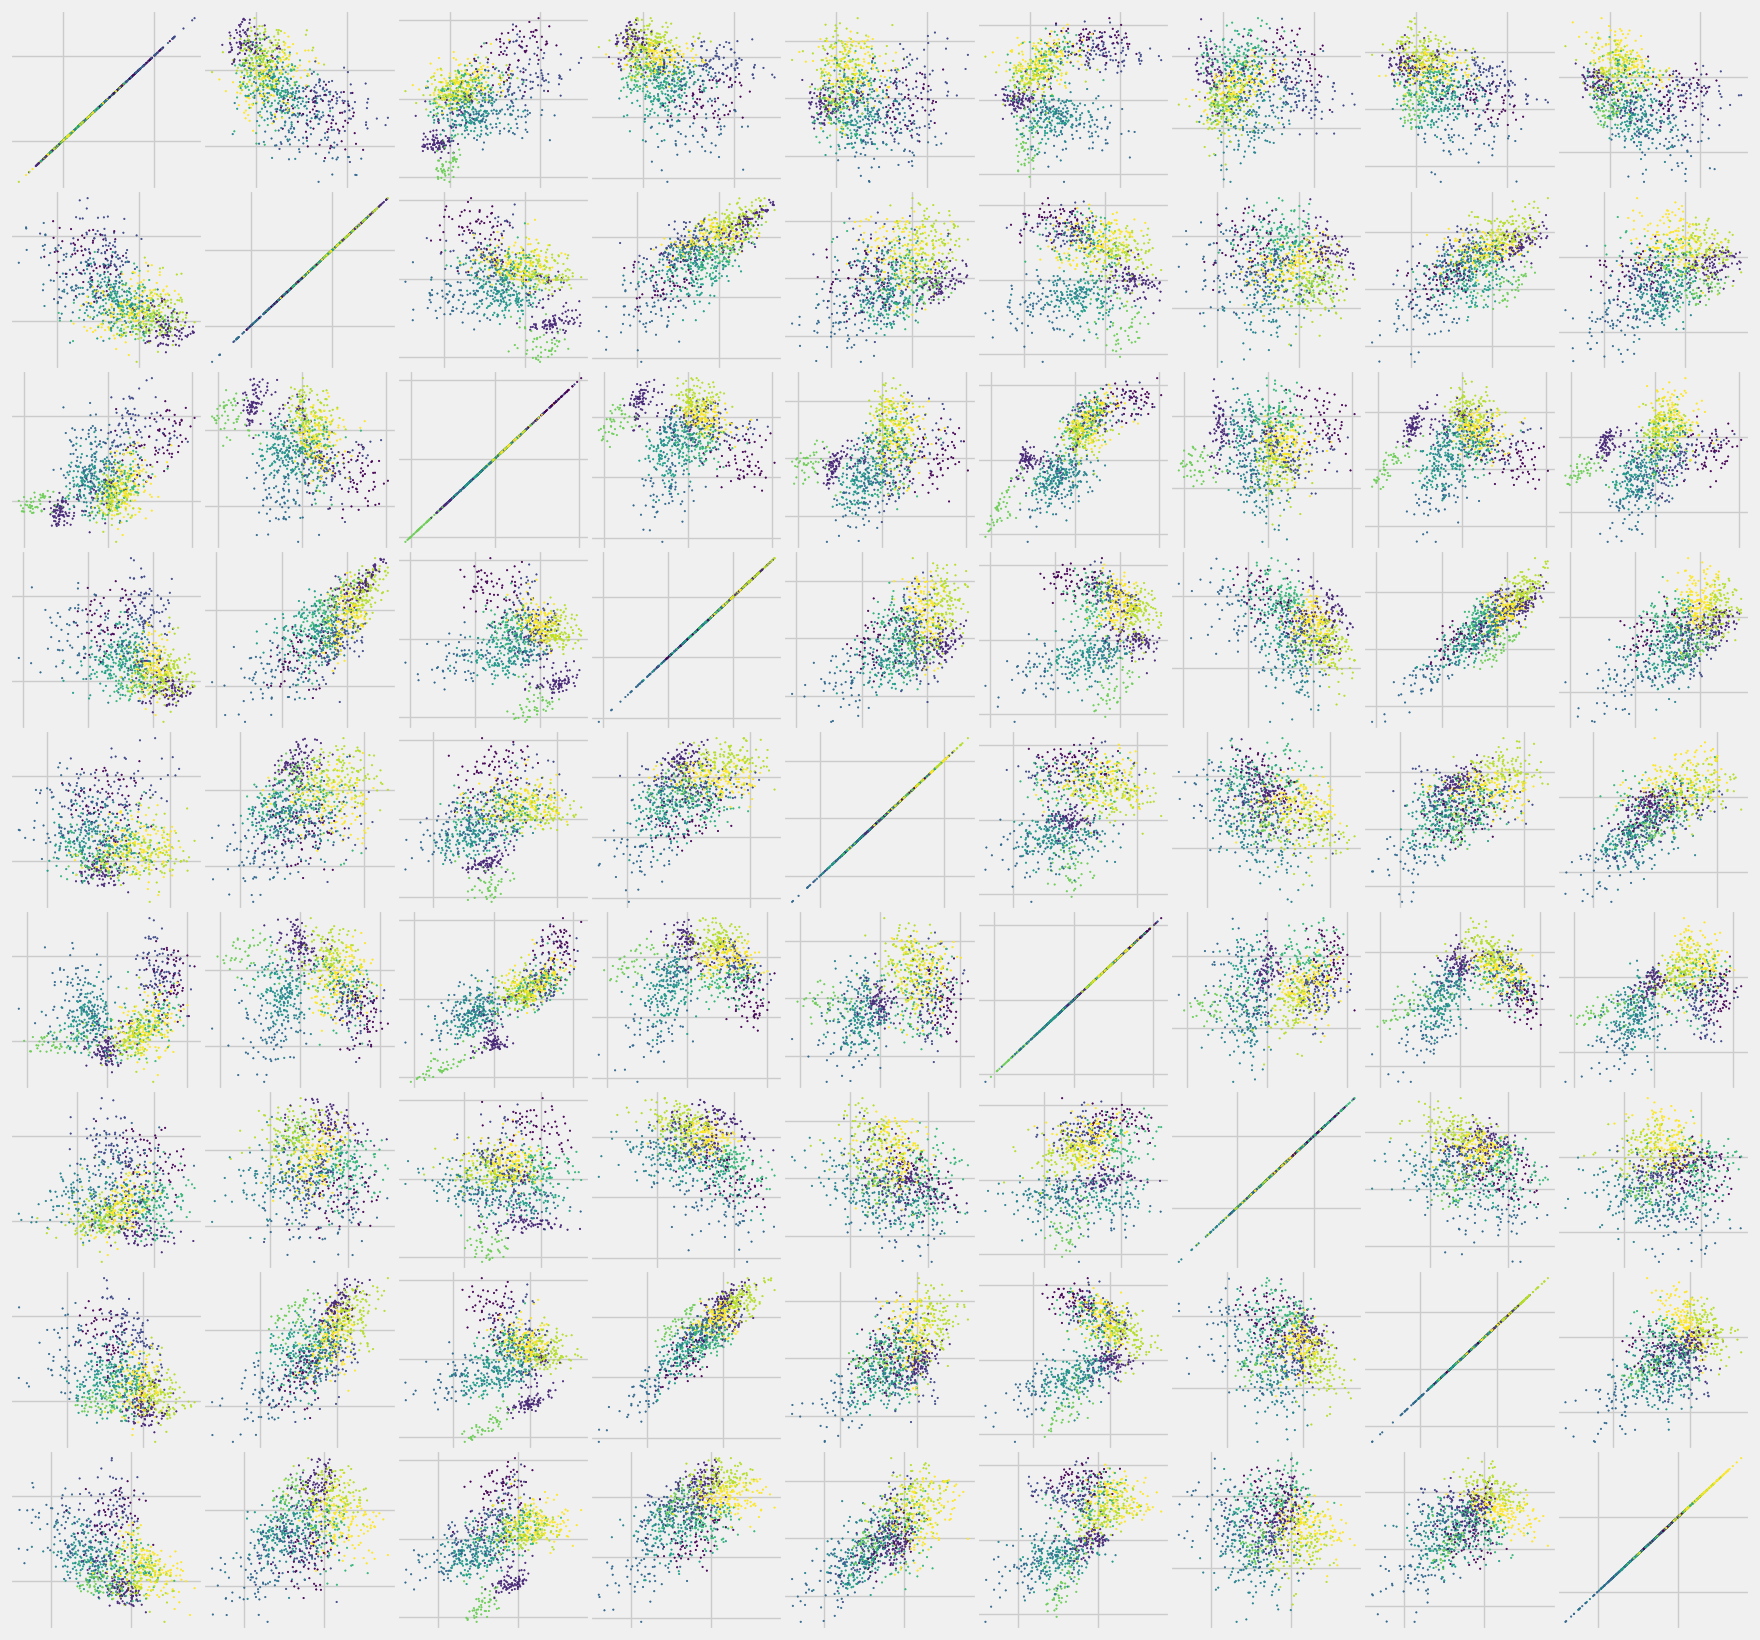

In [ ]:
subset = vectors[:1000]

fig, ax = plt.subplots(9,9, figsize=(20,20))

for i in range(9):
  for j in range(9):
    ax[i,j].scatter(subset[:,i], subset[:,j], s=1, c=kmeans.labels_[:1000])
    ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(vectors)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.026s...
[t-SNE] Computed neighbors for 60000 samples in 5.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

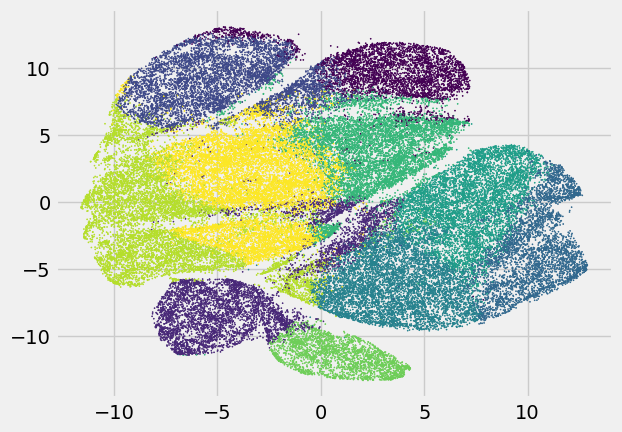

In [ ]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], s=.5, c=kmeans.labels_)

In [ ]:
fig = px.scatter_3d(x=tsne_results[:,0], y=tsne_results[:,1], z=tsne_results[:,2], color=kmeans.labels_, width=800, height=800)
fig.update_layout(scene=dict(
    xaxis_title='X Label',
    yaxis_title='Y Label',
    zaxis_title='Z Label'
))
fig.update_layout(title='3D Scatter Plot')
fig.update_traces(marker=dict(size=1))

# Display the plot
fig.show()